In [1]:
from mattergen.diffusion.diffusion_loss import *
from mattergen.common.data.chemgraph import *
import torch
import matplotlib.pyplot as plt
import json
from ase.io import read
import pandas as pd
from mattergen.common.data.chemgraph import ChemGraph
from mattergen.diffusion.diffusion_loss import environment_loss, energy
import os
import glob
import numpy as np
from matplotlib.patches import Patch
import ast
import re

/Data/auguste.de-lambilly/mattersim_torch/src/mattersim/__version__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


torch.Size([1011, 5])


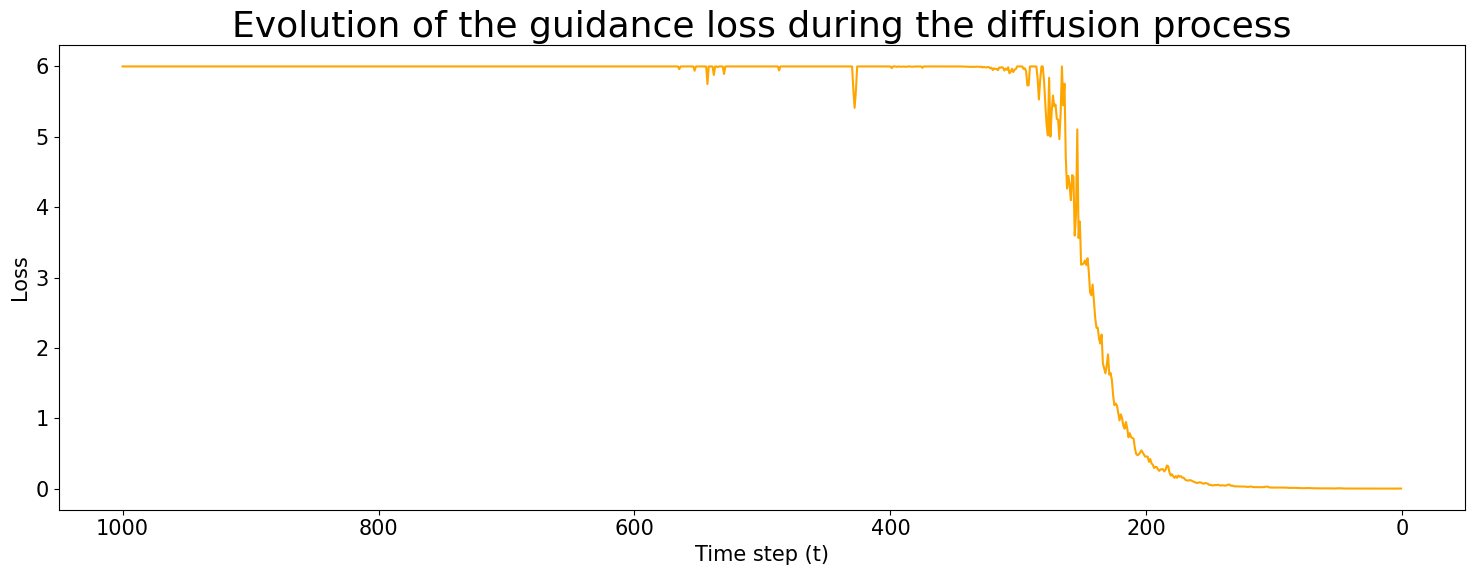

In [ ]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/TEST-Li-Co-O_guided-1_envCo-O6_g0.01_k0.01_True_3-2_huber_gpu0_2/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

matrix2 = torch.tensor(data[1:])

# Average every 8 time steps along the first axis
n = 8
num_points = matrix2.shape[0] // n
matrix2_avg = matrix2[:num_points * n].reshape(num_points, n, -1).mean(dim=1)

print(matrix2_avg.shape)

x = np.arange(1000)
x_transformed = 1000 - x
plt.figure(figsize=(15, 6))
plt.plot(x_transformed, matrix2_avg[:1000, 1].cpu().numpy(), color='orange')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of the guidance loss during the diffusion process',fontdict={'fontsize': 26})
plt.gca().invert_xaxis()  # Invert the x-axis
plt.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.show()

Found 2 files for X=3
Found 3 files for X=6


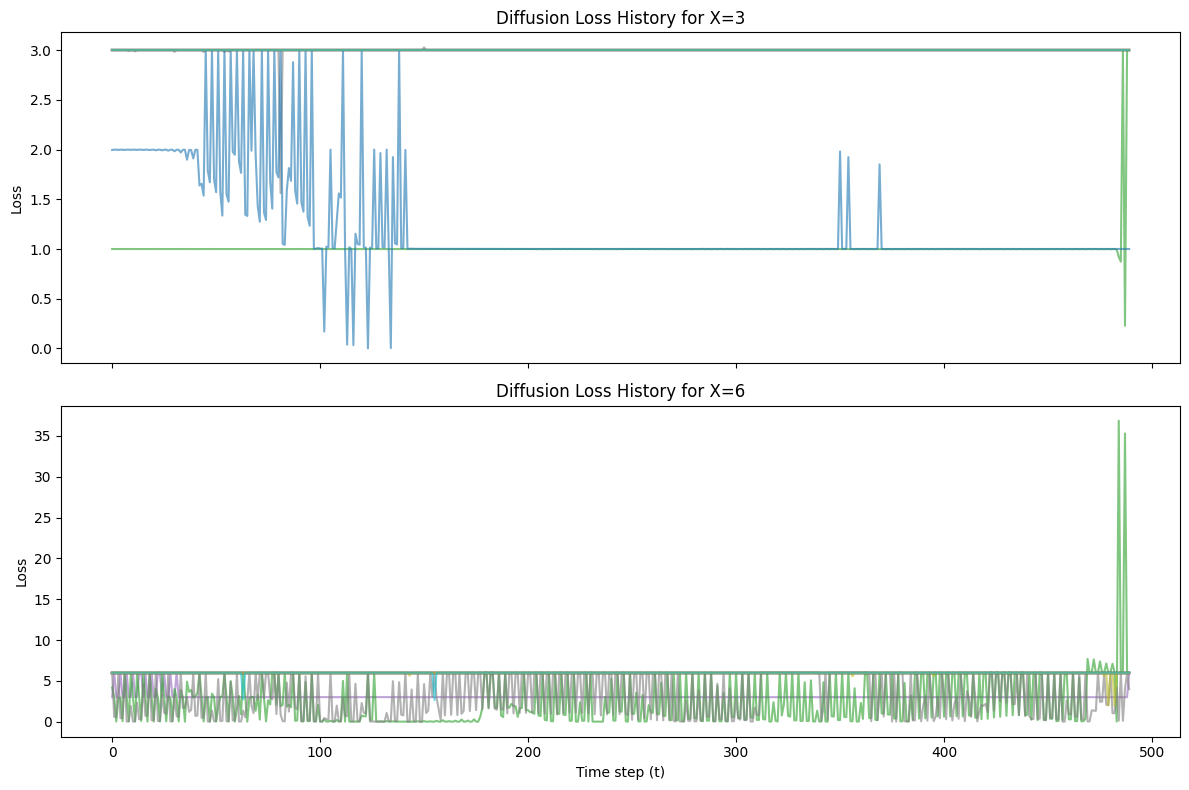

In [3]:
# Base directory
base_path = '/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_test'

# X values to group by
X_values = [3, 6]

# Prepare subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

for idx, X in enumerate(X_values):
    ax = axes[idx]
    pattern = os.path.join(base_path, f'diffusion_loss_history_{X}_*.txt')
    files = sorted(glob.glob(pattern))

    print(f"Found {len(files)} files for X={X}")

    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)

        matrix = torch.tensor(data[1:])
        if matrix.ndim != 2:
            print(f"Skipping {file}, unexpected shape: {matrix.shape}")
            continue

        for i in range(matrix.shape[1]):
            ax.plot(matrix[7600:, i].cpu().numpy(), label=f'Graph {i+1}', alpha=0.6)

    ax.set_title(f'Diffusion Loss History for X={X}')
    ax.set_ylabel('Loss')
    # ax.set_yscale('log')  # Uncomment if you want log scale

axes[-1].set_xlabel('Time step (t)')
plt.tight_layout()
# plt.legend()  # Optional: enable if not too crowded
plt.show()

torch.Size([3596, 100])


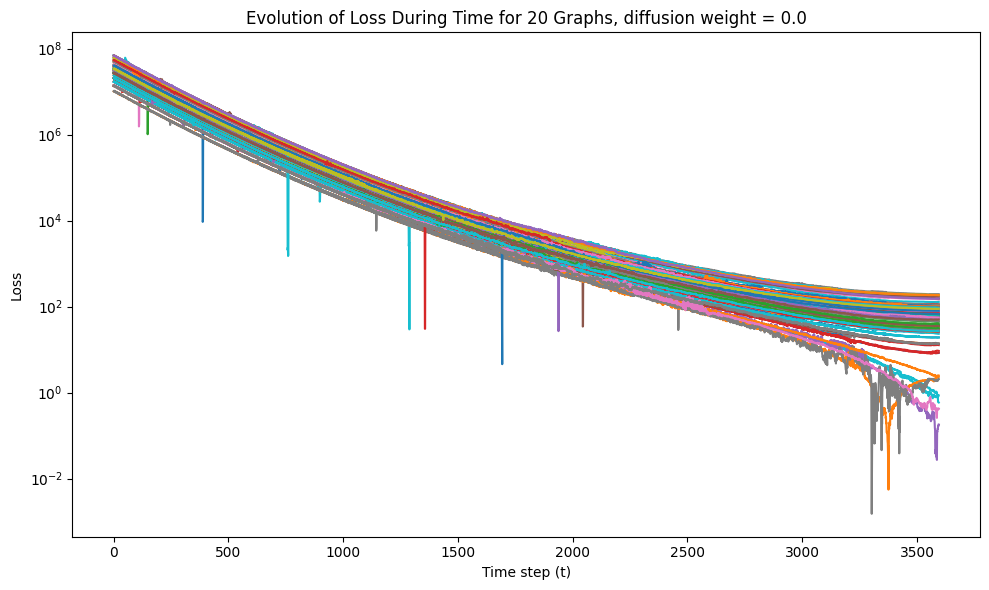

In [8]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [4]:
def compute_volumes_extxyz_file(extxyz_file):
    volumes = []
    # Read all frames from the extxyz file
    atoms_list = read(extxyz_file, index=':')
    for atoms in atoms_list:
        volumes.append(atoms.get_volume())
    return volumes


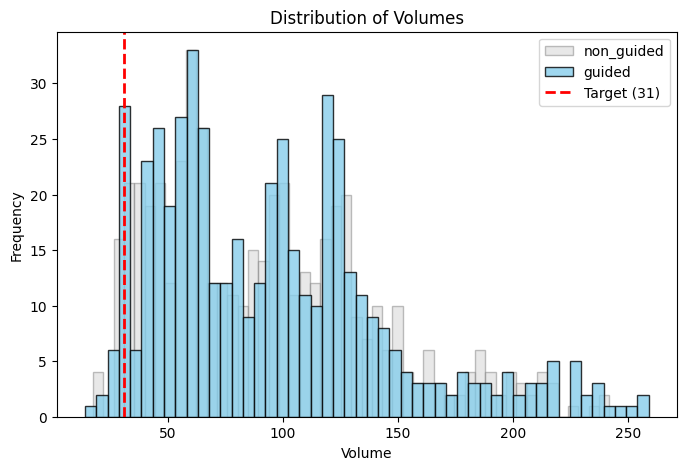

In [3]:
# Paths the extxyz files
extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

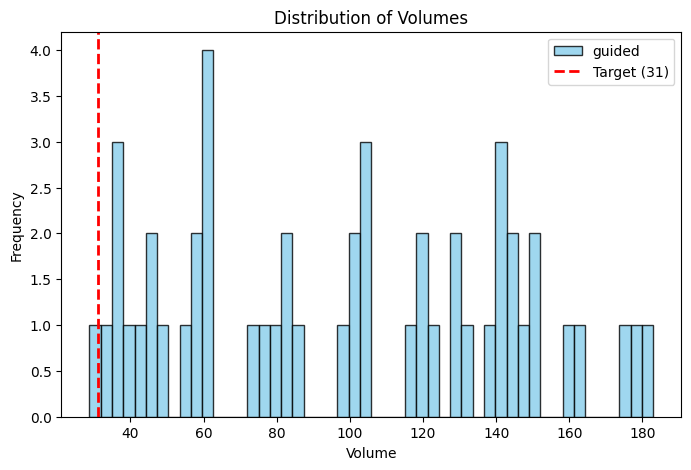

In [5]:
# Paths the extxyz files
#extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
#volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
#plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

In [6]:
extxyz_file = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/generated_crystals.extxyz"
output_csv = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/environment_loss_Co-O.csv"

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

atoms_list = read(extxyz_file, index=':')

results = []
for idx, atoms in enumerate(atoms_list):
    atomic_numbers = atoms.get_atomic_numbers()
    if co_Z in atomic_numbers and o_Z in atomic_numbers:
        cell = torch.tensor(atoms.cell, dtype=torch.float32)
        pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
        chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), pos=pos)
        target = {pair_str: 0.0}  # Dummy target, not used for value, just to trigger computation
        loss = int(environment_loss(chemgraph, None, target, alpha=800.0).item())
    else:
        loss = 0.0
    results.append({
        "structure_idx": idx,
        "Co-O_environment_loss": loss
    })

df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"Saved Co-O environment losses to {output_csv}")

Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_non_guided/environment_loss_Co-O.csv


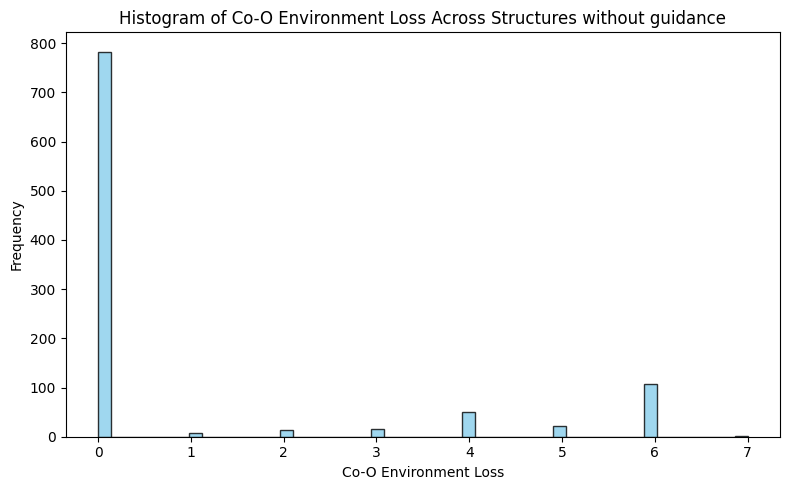

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(df['Co-O_environment_loss'], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Co-O Environment Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Co-O Environment Loss Across Structures without guidance')
plt.tight_layout()
plt.show()


In [8]:
extxyz_file = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/generated_crystals.extxyz"
output_csv = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/environment_loss_Co-O.csv"

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

atoms_list = read(extxyz_file, index=':')

results_ = []
for idx, atoms in enumerate(atoms_list):
    atomic_numbers = atoms.get_atomic_numbers()
    if co_Z in atomic_numbers and o_Z in atomic_numbers:
        cell = torch.tensor(atoms.cell, dtype=torch.float32)
        pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
        chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), pos=pos)
        target = {pair_str: 0.0}  # Dummy target, not used for value, just to trigger computation
        loss = int(environment_loss(chemgraph, None, target, alpha=800.0).item())
    else:
        loss = 0.0
    results_.append({
        "structure_idx": idx,
        "Co-O_environment_loss": loss
    })

df_ = pd.DataFrame(results_)
df_.to_csv(output_csv, index=False)
print(f"Saved Co-O environment losses to {output_csv}")

Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_guided_env_3-2/environment_loss_Co-O.csv


In [50]:
# Define the directories containing the CSV files
dir1 = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_3-2.csv"
dir2 = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_non_guided.csv"

# Read into DataFrames
df = pd.read_csv(dir1)
df_ = pd.read_csv(dir2)

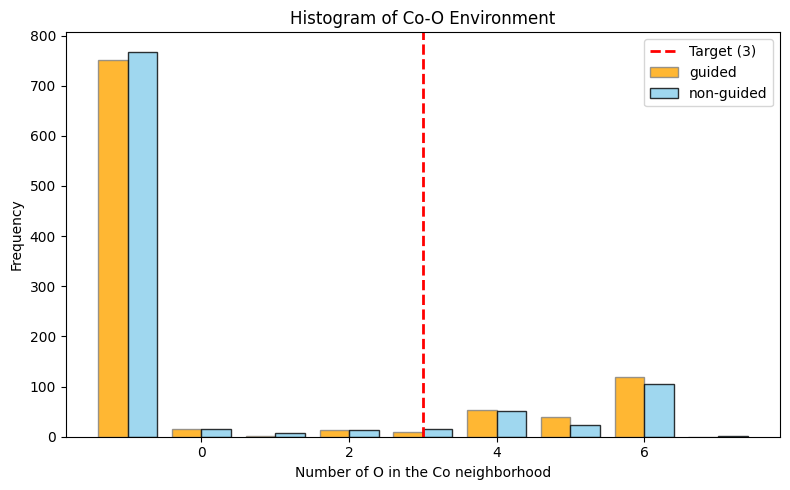

In [53]:
# Define integer bin centers
bin_centers = np.arange(
    min(df['Co-O_environment_loss'].min(), df_['Co-O_environment_loss'].min()),
    max(df['Co-O_environment_loss'].max(), df_['Co-O_environment_loss'].max()) + 1
)

# Shift for side-by-side bars
width = 0.4
left_bins = bin_centers - width/2
right_bins = bin_centers + width/2

plt.figure(figsize=(8, 5))
plt.bar(left_bins, np.histogram(df['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))[0],
        width=width, color='orange', edgecolor='gray', alpha=0.8, label='guided', align='center')
plt.bar(right_bins, np.histogram(df_['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))[0],
        width=width, color='skyblue', edgecolor='black', alpha=0.8, label='non-guided', align='center')
plt.axvline(3, color='red', linestyle='--', linewidth=2, label='Target (3)')
plt.xlabel('Number of O in the Co neighborhood')
plt.ylabel('Frequency')
plt.title('Histogram of Co-O Environment')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# Directory containing the extxyz files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
extxyz_files = glob.glob(os.path.join(base_dir, "**", "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Co-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Co-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if co_Z in atomic_numbers and o_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = int(environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Co-O_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Co-O environment losses to {output_csv}")

Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_non_guided.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_3-0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_3-4_huber_gpu0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_test_0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env6_g500.0_3-2_huber_gpu0.csv (already exists)


/tmp/ipykernel_1561456/3028823384.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_3-2_huber_gpu0.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_3-2_huber_gpu9.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env3_g10.0_3-2_huber_gpu3.csv
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_g500.0_3-2_huber_gpu0.csv (already exists)
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env6_g0.01_3-2_huber_gpu0.csv
Saved Co-O environment losses to /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided_env3_g10.0_3-2_huber_gpu6.csv
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O/environment_loss_Co-O_guided2_env3_3-2_real+.csv (already exists)
Skippin

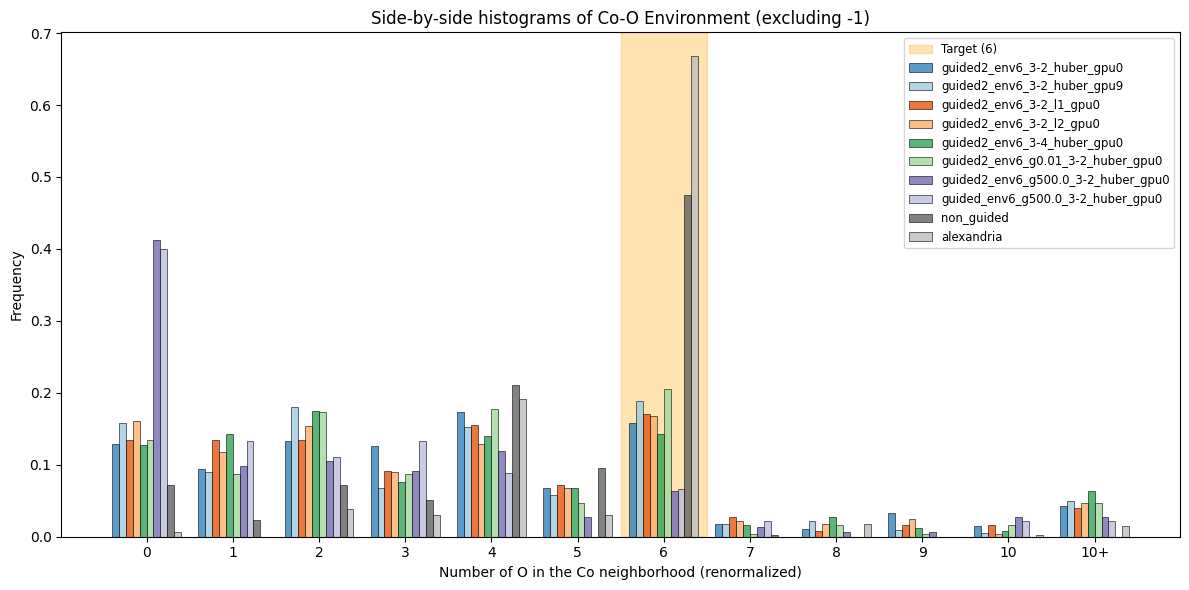

In [3]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env6*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


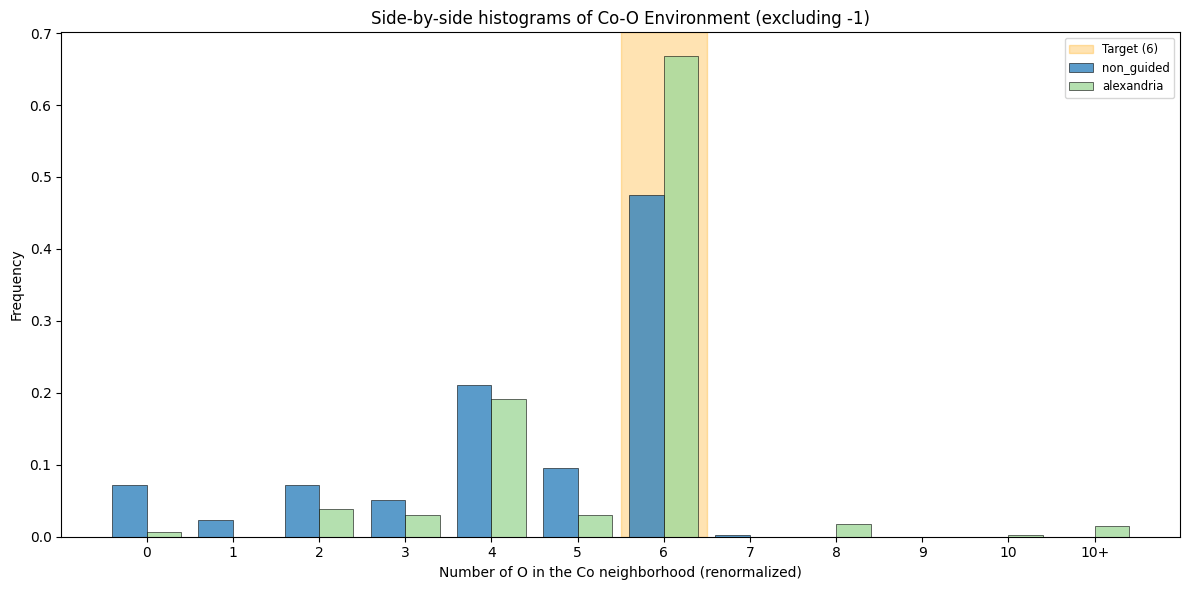

In [3]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = []#sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env6*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


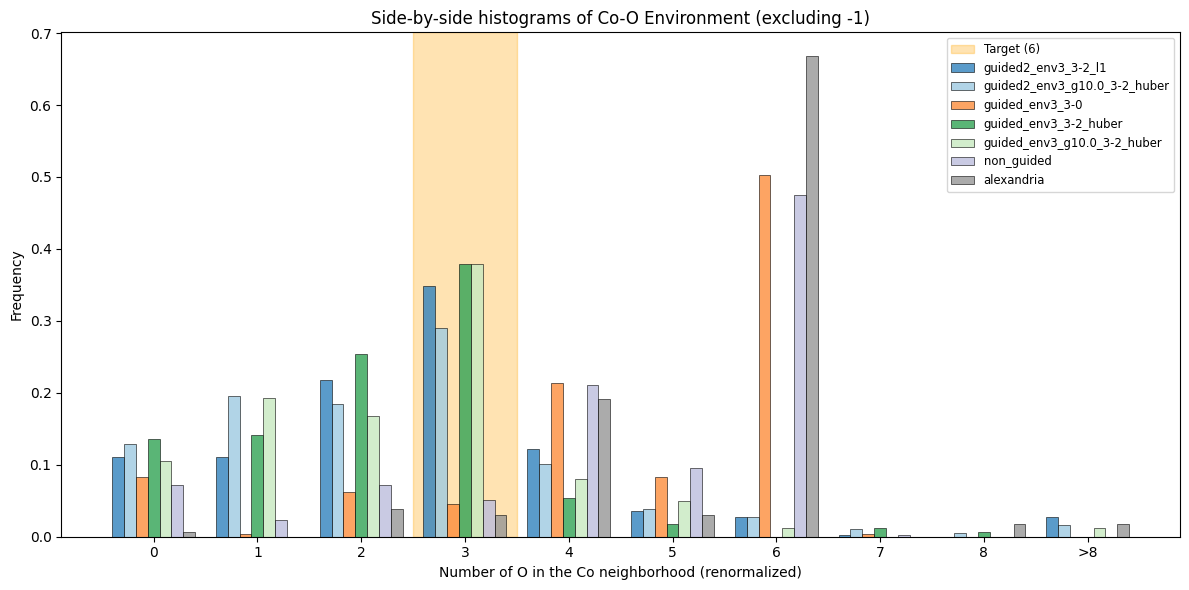

In [17]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env3*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=9)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 3
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize so sum = 1000
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    label = re.sub(r'_gpu\d+', '', label)  # Remove GPU suffix if present
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 9 else ">8" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


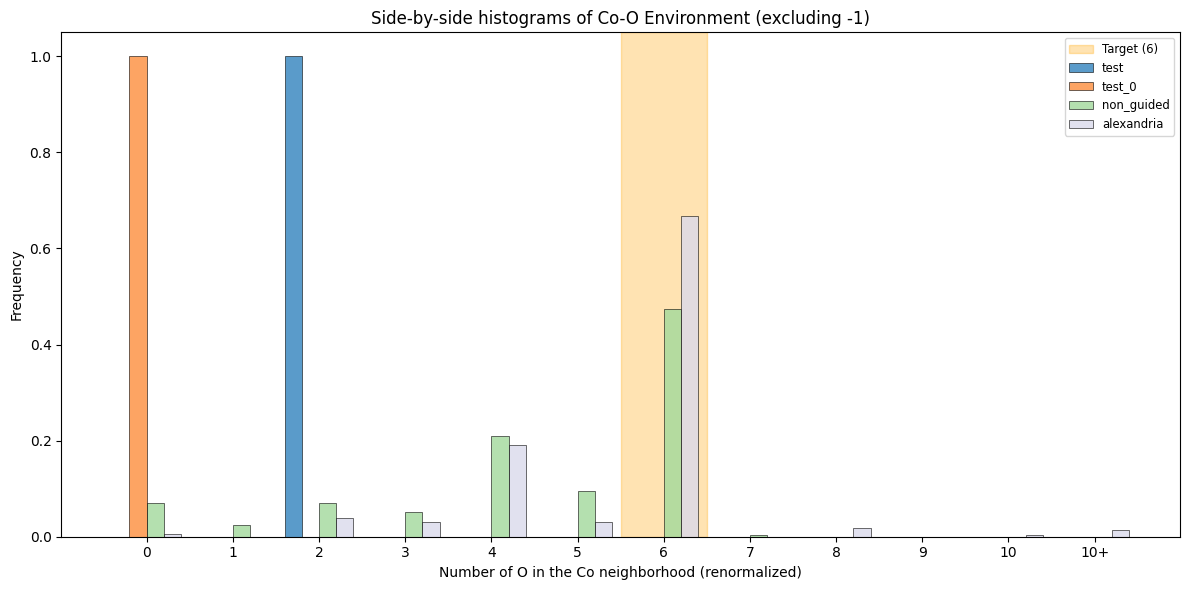

In [9]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_test*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


125; 117 : 
Mo Si B P : B-P (>=1 pas forcément chaque B)
Cu Si P : (Cu-P:4) 2.3 (2.28-2.5); (Cu-Cu: 0?) 3.7
Ba Cu P : 

Ex: BaCu2P4, Ba8Cu16P30

Cu Si P X : (Cu-P:4) 2.2-2.6; Cu-Cu : 0 en dessous de 2.9
X : Ba, Sr, Ca

proximité avec des positions "prototypes" (pas lié aux distances):
distances à Cr5B3, Mo2B4 et W5Si3

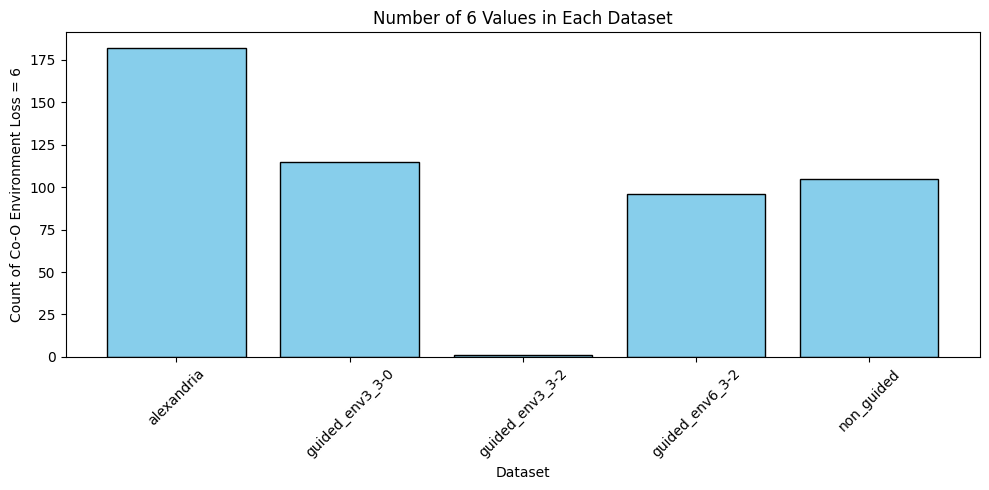

In [2]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O*.csv"), recursive=True))

labels = []
counts_6 = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count_6 = (df['Co-O_environment_loss'] == 6).sum()
    # Extract label from filename
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace(".csv", "")
    labels.append(label)
    counts_6.append(count_6)

plt.figure(figsize=(10, 5))
plt.bar(labels, counts_6, color='skyblue', edgecolor='black')
plt.xlabel('Dataset')
plt.ylabel('Count of Co-O Environment Loss = 6')
plt.title('Number of 6 Values in Each Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

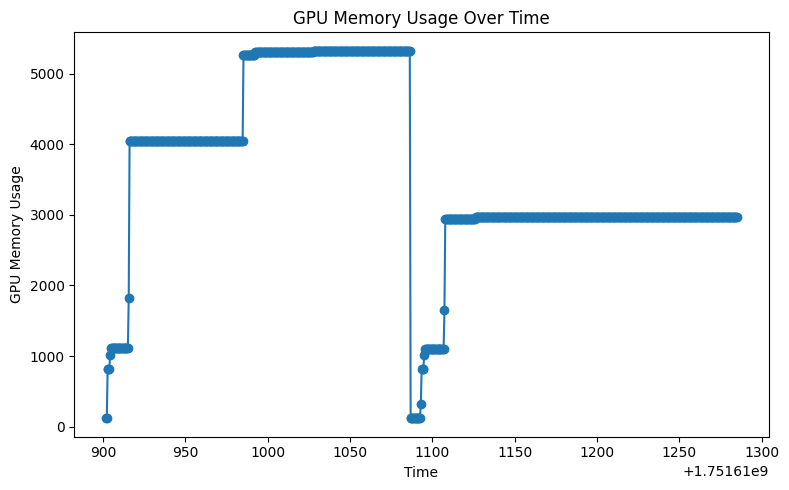

In [9]:
# Read and plot the values from log_gpu_mem.txt
log_file = "/Data/auguste.de-lambilly/mattergenbis/log_gpu_mem.txt"
times = []
values = []

with open(log_file) as f:
    for line in f:
        t, v = line.strip().split('\t')
        times.append(float(t))
        # v is like '[116]', '[4047]', etc.
        v_num = ast.literal_eval(v)[0]  # Safely parse the list and get the first value
        values.append(v_num)

plt.figure(figsize=(8, 5))
plt.plot(times, values, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('GPU Memory Usage')
plt.title('GPU Memory Usage Over Time')
plt.tight_layout()
plt.show()

In [3]:
# Directory containing the extxyz files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f"
extxyz_files = glob.glob(os.path.join(base_dir, "**", "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Co-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Co-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if co_Z in atomic_numbers and o_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = int(environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Co-O_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Co-O environment losses to {output_csv}")

Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f/environment_loss_Co-O_guided2_envCo-O6_k0.01_False_3-2_huber_gpu0.csv (already exists)
Skipping /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f/environment_loss_Co-O_guided2_envCo-O6_k0.1_False_3-2_huber_gpu0.csv (already exists)


UnknownFileTypeError: Empty file: /Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f/generated_crystals_guided-3_envCo-O6_k0.01_False_3-2_huber_gpu0.extxyz

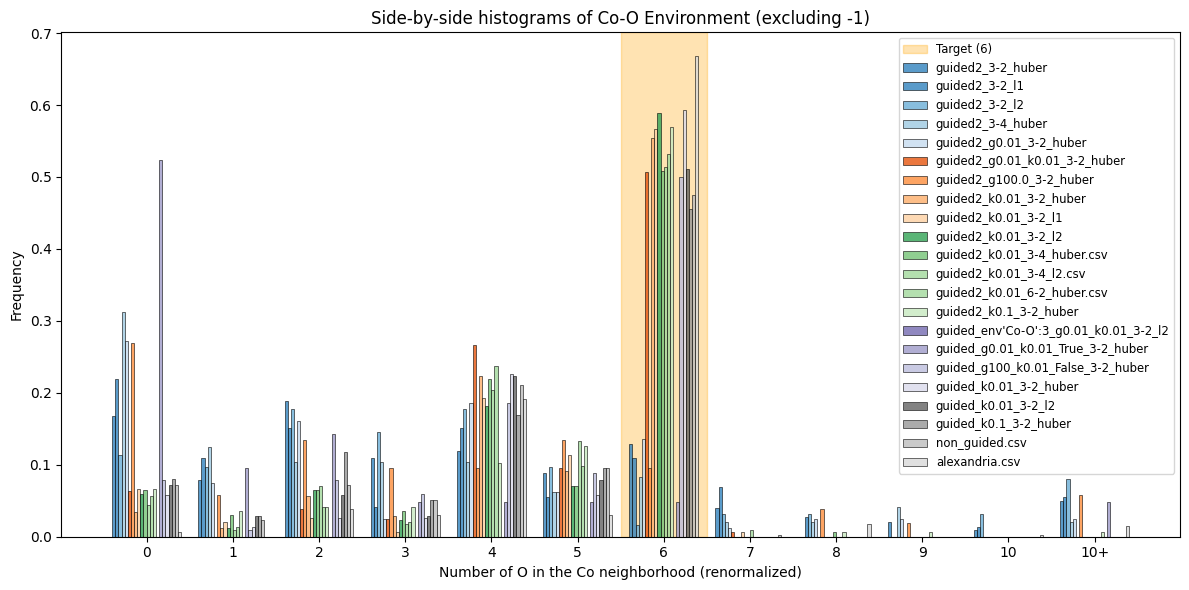

In [4]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0.csv", "").replace("_env'Co-O':6", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


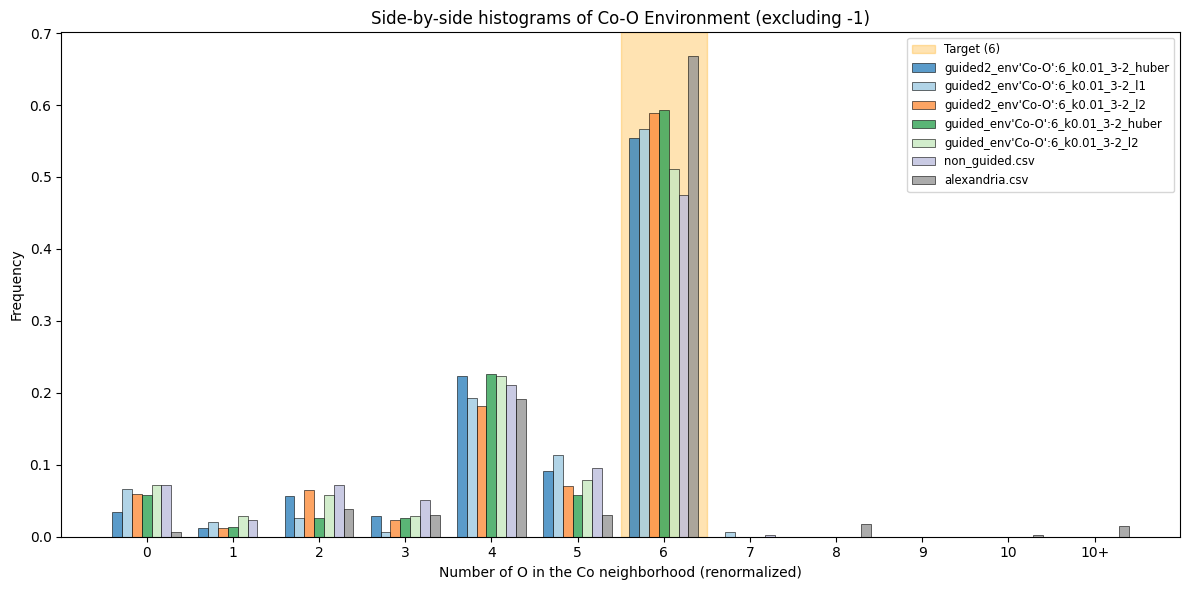

In [4]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env*6_k0.01_3-2*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0.csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


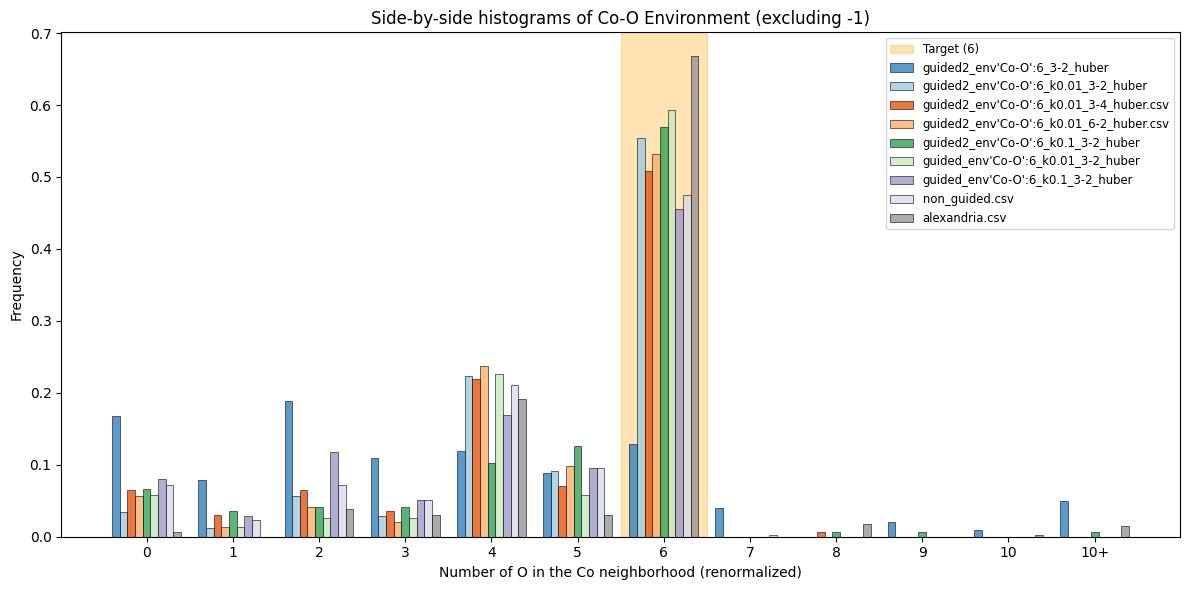

In [5]:
# Directory containing the CSV files
base_dir = "/Data/auguste.de-lambilly/mattergenbis/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "**", "environment_loss_Co-O_guided*_env*6_k*_huber*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))
csv_files = [os.path.join(base_dir, "environment_loss_Co-O_guided2_env'Co-O':6_3-2_huber_gpu0.csv")]+ csv_files

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0.csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


In [4]:
from ase.io import read, write

# Load all frames from the extxyz file
atoms_list = read("/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/generated_crystals_guided2_envCo-O6_g0.01_k0.01_True_3-2_huber_gpu0.extxyz", index=":")

# Write each frame to a separate CIF file
for i, atoms in enumerate(atoms_list):
    write(f"/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/norm/Li-Co-O_{i:04d}.cif", atoms)

In [2]:
# Directory containing the extxyz files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
extxyz_files = glob.glob(os.path.join(base_dir,  "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Co and O
co_Z = Element("Co").Z
o_Z = Element("O").Z
pair_str = "Co-O"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Co-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Co-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if co_Z in atomic_numbers and o_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = int(environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Co-O_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Co-O environment losses to {output_csv}")

Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_guided_envCo-O6_g0.0001_k0.0001_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_guided_envCo-O6_k0.01_False0_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_energies.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_guided_envCo-O6_g0.0001_k0.00001_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_guided_envCo-O6_g0.0001_k0.00005_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/environment_loss_Co-O_guided_envCo-O6_g0.00001_k0.00001_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f/e

/tmp/ipykernel_412712/3904191081.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


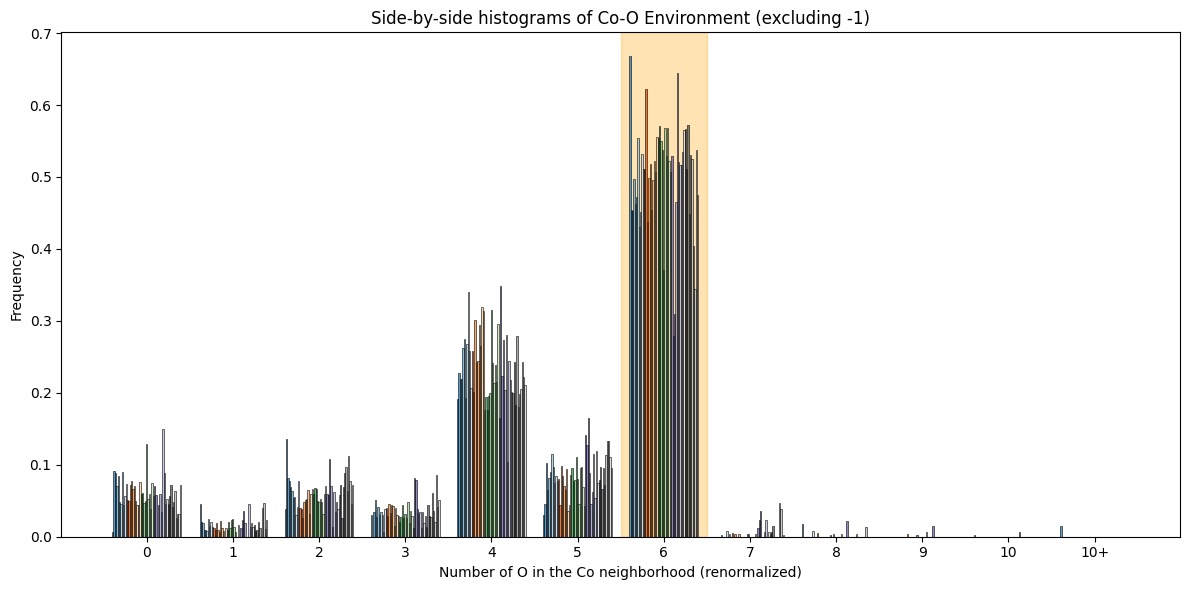

In [3]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_*.csv"), recursive=True))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0.csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)')
plt.ylabel('Frequency')
plt.title('Side-by-side histograms of Co-O Environment (excluding -1)')
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
#plt.legend(fontsize='small', loc='upper right')
plt.tight_layout() 
plt.show()


169 Huber 296
175 L1 318
164 L2 305
160 Non-guided 337
223 Alexandria database 334
145 Non-guided 259


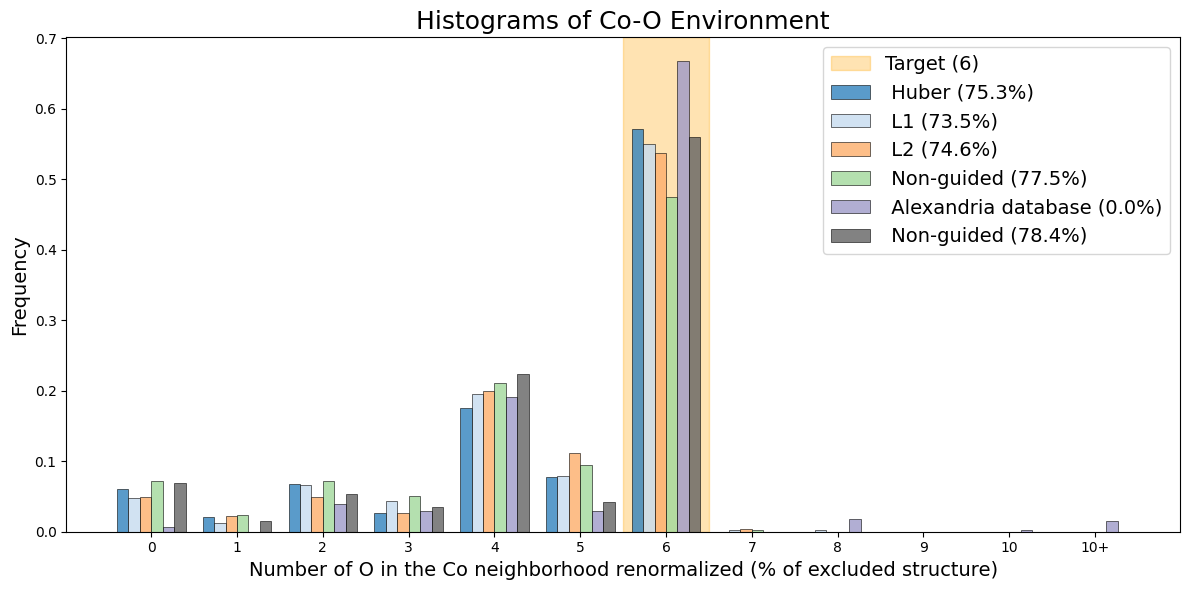

In [6]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided-1_envCo-O6_k0.01_*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

labels = ["Huber", "L1", "L2", "Non-guided", "Alexandria database", "Non-guided"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    print(counts[6], labels[i], total)
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)" #
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)
    

plt.xlabel(f'Number of O in the Co neighborhood renormalized (% of excluded structure)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


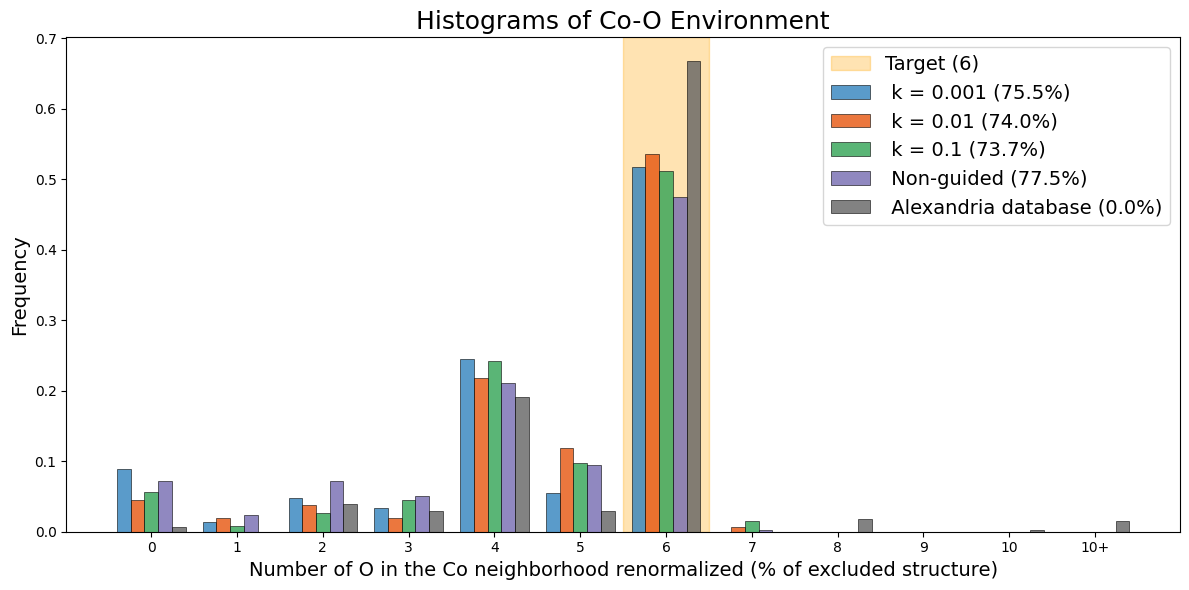

In [5]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided2_envCo-O6_k*huber_gpu0.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

labels = ["k = 0.001", "k = 0.01", "k = 0.1", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel(f'Number of O in the Co neighborhood renormalized (% of excluded structure)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


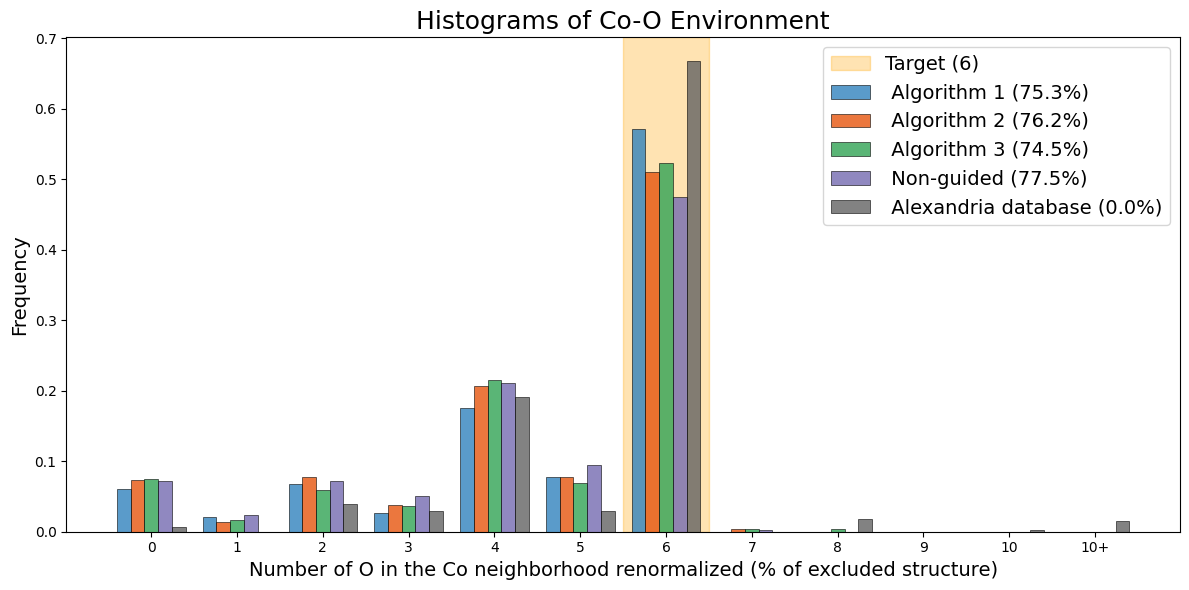

In [6]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided-*_envCo-O6_k0.01*huber_gpu0.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))
csv_files[0], csv_files[1] = csv_files[1], csv_files[0]  # Swap to have algo 1 first

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

labels = ["Algorithm 1", "Algorithm 2", "Algorithm 3", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)"
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel(f'Number of O in the Co neighborhood renormalized (% of excluded structure)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


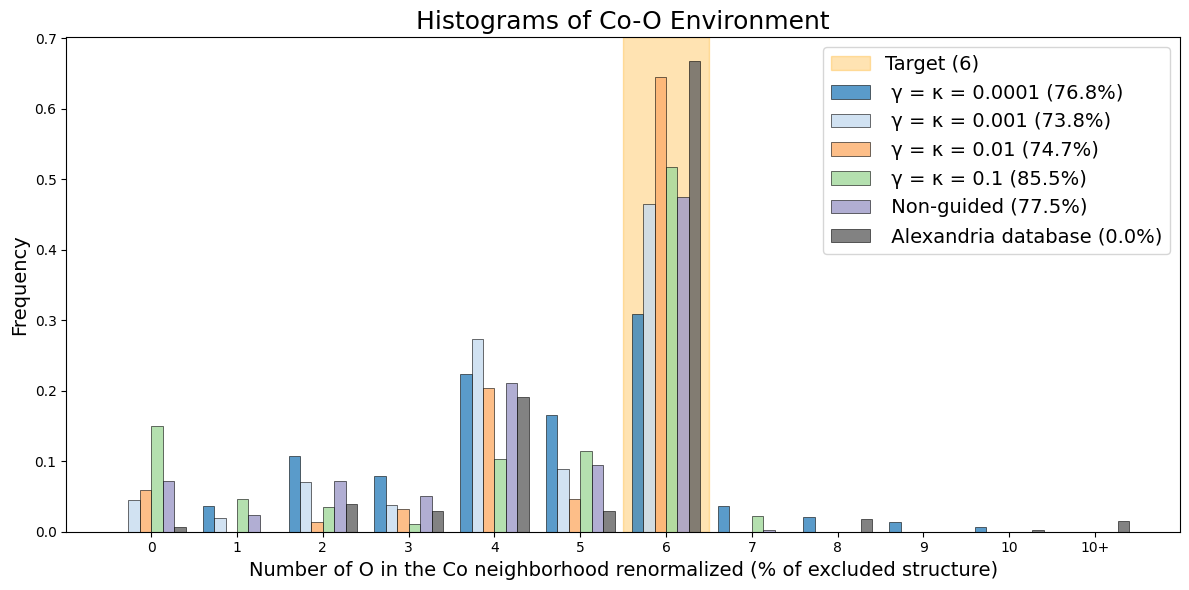

In [14]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided2*True_3-2_huber_gpu0.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))
# Remove the 3rd element (index 2) from csv_files if it exists
if len(csv_files) > 3:
    csv_files.pop(3)
# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

labels = ["γ = κ = 0.0001", "γ = κ = 0.001", "γ = κ = 0.01", "γ = κ = 0.1", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "").replace("_True_3-2_huber", "").replace("guided", ".")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel(f'Number of O in the Co neighborhood renormalized (% of excluded structure)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


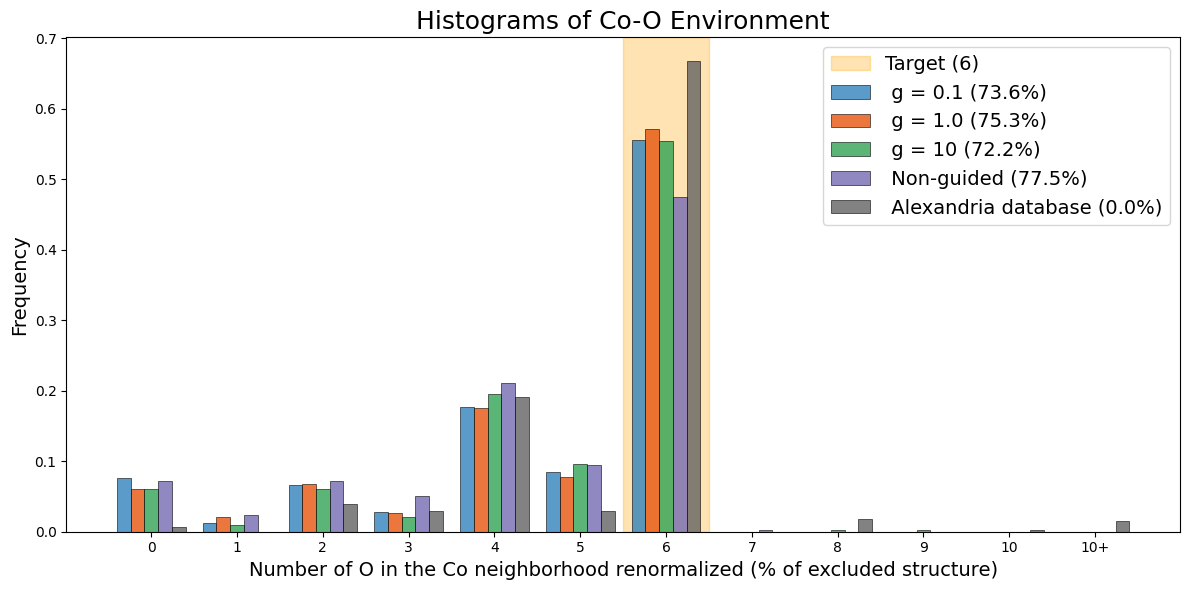

In [2]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided-1_envCo-O6_g*False*huber_gpu0.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_guided-1_envCo-O6_k0.01_False_3-2_huber_gpu0.csv"))
csv_files[-1], csv_files[-2] = csv_files[-2], csv_files[-1]
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (6) with a vertical strip
target = 6
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (6)')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel(f'Number of O in the Co neighborhood renormalized (% of excluded structure)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


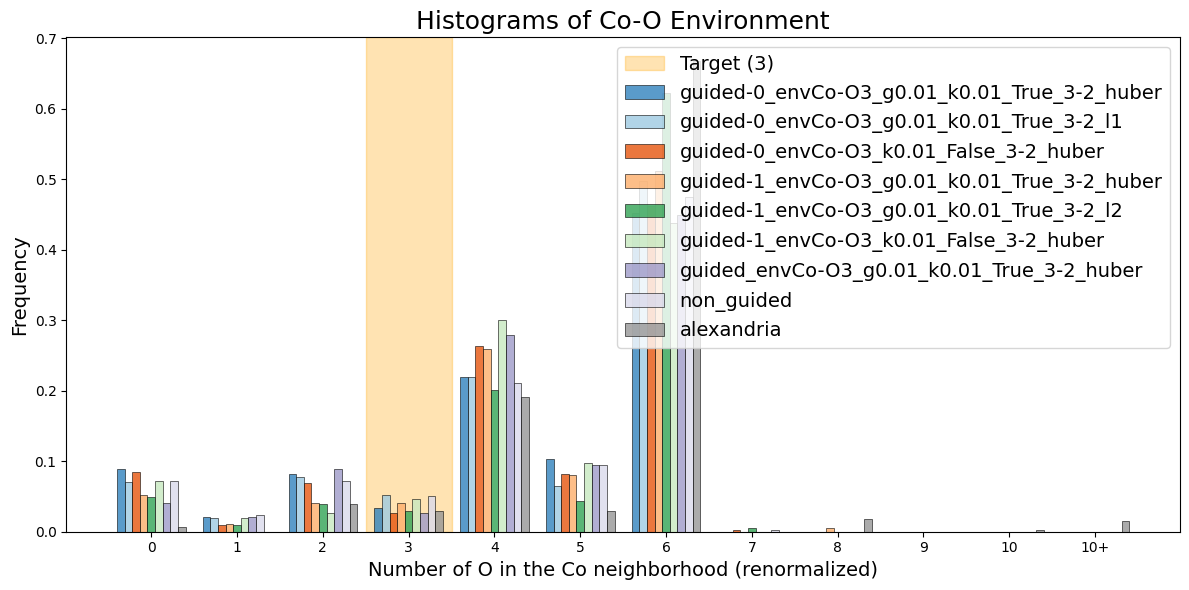

In [9]:
# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Co-O_guided*_envCo-O3_*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value (3) with a vertical strip
target = 3
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label='Target (3)')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    #label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "")
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


0.2747603833865815 0_envCo-O4_g0.01_k0.01_True_3-2_huber
0.19230769230769232 0_envCo-O4_g0.01_k0.01_True_3-2_l1
0.2673611111111111 0_envCo-O4_k0.01_False_3-2_huber
0.34074074074074073 0_envCo-O4_k0.01_False_3-2_l1
0.25874125874125875 0_envCo-O4_k0.01_False_3-2_l2
0.24271844660194175 1_envCo-O4_g0.01_k0.01_True_3-2_huber
0.24444444444444444 1_envCo-O4_k0.01_False_3-2_huber
0.294478527607362 1_envCo-O4_k0.01_False_3-2_l1
0.26479750778816197 1_envCo-O4_k0.01_False_3-2_l2
0.31451612903225806 2_envCo-O4_g0.01_k0.01_True_3-2_huber
0.24183006535947713 2_envCo-O4_k0.01_False_3-2_huber
0.21428571428571427 2_envCo-O4_k0.01_False_3-2_l1
0.23870967741935484 2_envCo-O4_k0.01_False_3-2_l2
0.21068249258160238 non_guided
0.19161676646706588 alexandria


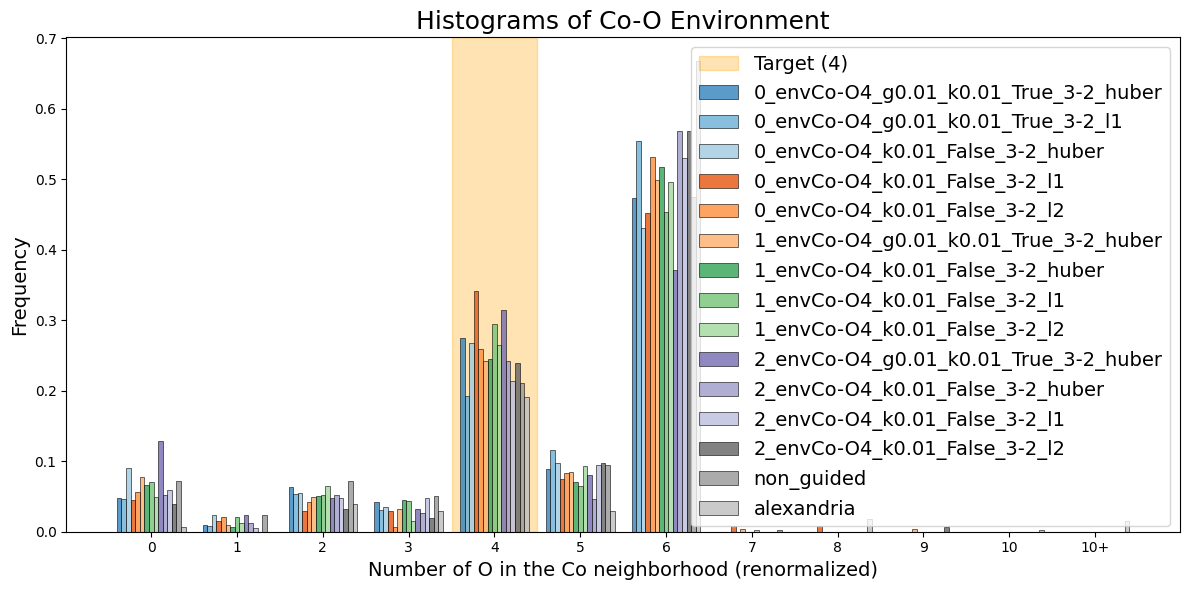

In [4]:
target = 4

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, rf"environment_loss_Co-O_guided*_envCo-O{target}_*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value with a vertical strip
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label=f'Target ({target})')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    #label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    print(counts[target], label)
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


0.294478527607362  Algo 1 (72.8%)
0.34074074074074073  Algo 2 (77.5%)
0.31451612903225806  Algo 3 (79.3%)
0.21068249258160238  Non-guided (77.5%)
0.19161676646706588  Alexandria database (0.0%)


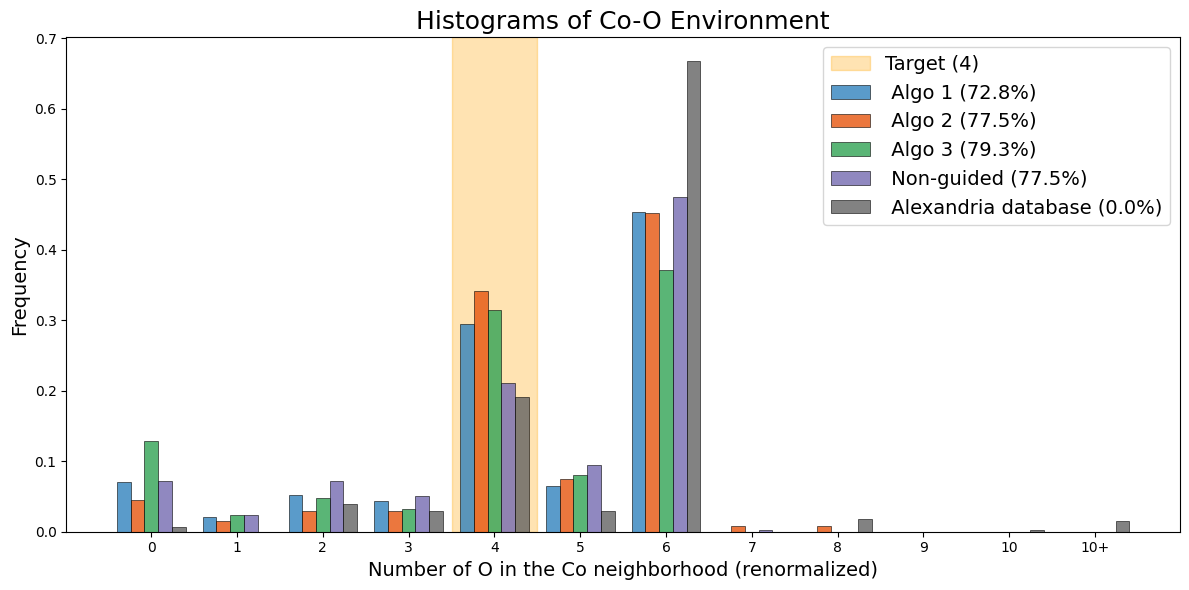

In [12]:
target = 4

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Li-Co-O_f"
csv_files = []#sorted(glob.glob(os.path.join(base_dir, rf"environment_loss_Co-O_guided*_envCo-O{target}_*.csv"), recursive=True))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_guided-1_envCo-O4_k0.01_False_3-2_l1_gpu0.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_guided-0_envCo-O4_k0.01_False_3-2_l1_gpu0.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_guided-2_envCo-O4_g0.01_k0.01_True_3-2_huber_gpu0.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_non_guided.csv"))
csv_files.append(os.path.join(base_dir, "environment_loss_Co-O_alexandria.csv"))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Co-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Co-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Co-O_environment_loss'] = df_filtered['Co-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Co-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value with a vertical strip
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label=f'Target ({target})')

labels = ["Algo 1", "Algo 2", "Algo 3", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Co-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    #label = base.replace("environment_loss_Co-O_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    print(counts[target], label)
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Co neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Co-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


In [3]:
# Directory containing the extxyz files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f"
extxyz_files = glob.glob(os.path.join(base_dir,  "generated_crystals*.extxyz"), recursive=True)

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'volume_loss_Co-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "volume_loss_Co-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        atoms.cell = atoms.cell + np.eye(3) * 1e-8 
        cell = torch.tensor(atoms.cell, dtype=torch.float32)
        pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
        chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
        target = 0  # 0 target, to compute the actual volume
        loss = volume_loss(chemgraph, None, target).item()*10**5
        results.append({
            "structure_idx": idx,
            "volume_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved volume losses to {output_csv}")

Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_guided-1_env30.935_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_non_guided.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_guided-0_env30.935_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)


/users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_guided-0_env30.935_g0.01_k0.01_True_3-2_huber_gpu0.csv
/users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_guided-1_env30.935_g0.01_k0.01_True_3-2_huber_gpu0.csv
/users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f/volume_loss_Co-O_non_guided.csv


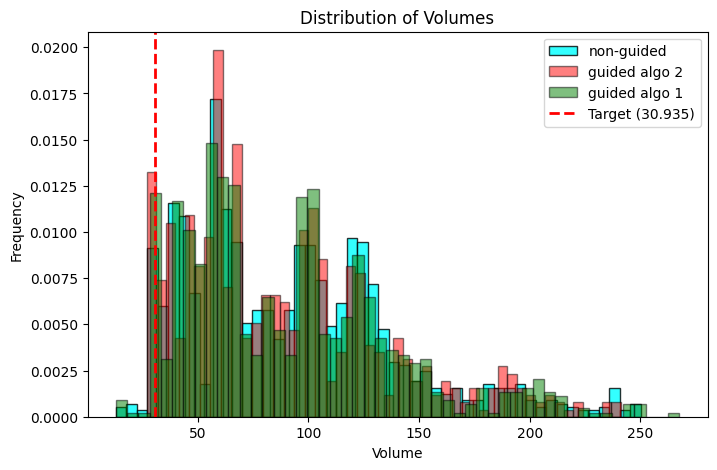

In [5]:
target = 30.935

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Pd-Ni-H_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, "volume_loss_Co-O*.csv"), recursive=True))

# Collect all volume_loss values from all files
all_volumes = []
for csv_file in csv_files:
    print(csv_file)
    df = pd.read_csv(csv_file)
    all_volumes.append(df['volume_loss'].tolist())


plt.figure(figsize=(8, 5))
# Plot "guided" on top
plt.hist(all_volumes[2], bins=50, color='cyan', edgecolor='black', alpha=0.8, label='non-guided', density=True)
# Plot "non guided" as background
plt.hist(all_volumes[0], bins=50, color='red', edgecolor='black', alpha=0.5, label='guided algo 2', density=True)
plt.hist(all_volumes[1], bins=50, color='green', edgecolor='black', alpha=0.5, label='guided algo 1', density=True)
plt.axvline(target, color='red', linestyle='--', linewidth=2, label=f'Target ({target})')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

In [7]:
from ase.io import read, write
import os

# Load all frames from the extxyz file
atoms_list = read("/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/generated_crystals_guided-1_envSi-O6_g10.0_True_3-2_huber_gpu0.extxyz", index=":")

# Write each frame to a separate CIF file
for i, atoms in enumerate(atoms_list):
    out_dir = os.path.dirname(f"/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/Si-O_guided_1/Si-O_{i:04d}.cif")
    os.makedirs(out_dir, exist_ok=True)
    write(f"/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/Si-O_guided_1/Si-O_{i:04d}.cif", atoms)

In [3]:
# Directory containing the extxyz files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f"
extxyz_files = glob.glob(os.path.join(base_dir,  "generated_crystals*.extxyz"), recursive=True)
extxyz_files.append("/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_guided/Si-O_f/generated_crystals_guided-1_envSi-O6_g0.01_k0.01_True_3-2_huber_gpu0.extxyz")

# Atomic numbers for Co and O
si_Z = Element("Si").Z
o_Z = Element("O").Z
pair_str = "Si-O"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Si-O' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Si-O").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if si_Z in atomic_numbers and o_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = int(environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Si-O_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Si-O environment losses to {output_csv}")

/tmp/ipykernel_715482/946769373.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_guided-0_envSi-O6_g0.01_k0.01_True_3-2_huber_gpu0.csv
Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_guided-1_envSi-O6_g0.01_k0.01_True_3-2_huber_gpu0.csv
Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_guided-1_envSi-O6_g0.01_k0.01_True_3-2_huber_gpu0.csv
Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_guided-1_envSi-O6_g0.01_k0.01_True_3-2_l1_gpu0.csv
Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_guided-1_envSi-O6_g0.01_k0.01_True_3-2_l1_gpu0.csv
Saved Si-O environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f/environment_loss_Si-O_non_guided.csv
Saved Si-O environment losses to /users/eleves-b/2021/a

0.02348993288590604 environment_loss_Si-O
0.26827171109200343 0_envSi-O6_True_3-2_huber
0.03773584905660377 0_envSi-O6_g0.01_k0.01_True_3-2_huber
0.10046948356807511 0_envSi-O6_g10.0_k10.0_True_3-2_huber
0.20205479452054795 1_envSi-O6_True_3-2_huber
0.03350515463917526 1_envSi-O6_g0.01_k0.01_True_3-2_huber
0.01810344827586207 1_envSi-O6_g0.01_k0.01_True_3-2_l1
0.05802047781569966 1_envSi-O6_g0.1_k0.1_True_3-2_huber
0.1892123287671233 1_envSi-O6_g10.0_True_3-2_huber
0.11875 1_envSi-O6_g10.0_k10.0_True_3-2_huber
0.11450381679389313 1_envSi-O6_k10.0_True_3-2_huber
0.02906208718626156 1_envSi-O6_vlad_g0.01_k0.01_True_3-2_huber
0.022727272727272728 non_guided


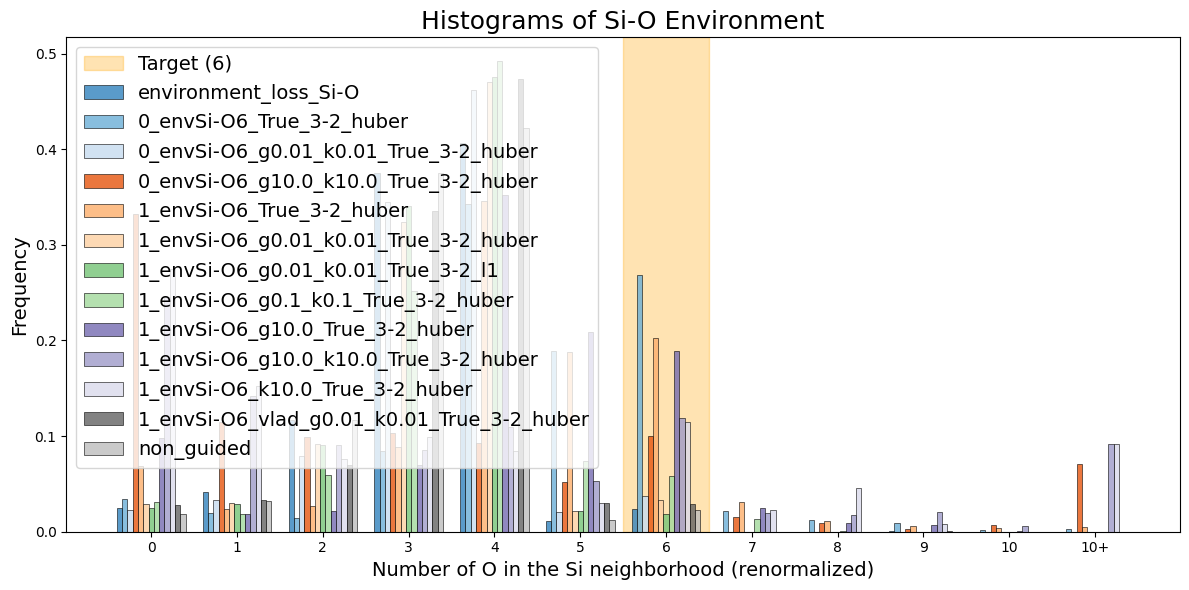

In [5]:
target = 6

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Si-O_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, rf"environment_loss_*.csv"), recursive=True))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Si-O_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Si-O_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Si-O_environment_loss'] = df_filtered['Si-O_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Si-O_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value with a vertical strip
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label=f'Target ({target})')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Si-O_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    #label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    label = base.replace("environment_loss_Si-O_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    print(counts[target], label)
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of O in the Si neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Si-O Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout() 
plt.show()


In [ ]:
# Directory containing the extxyz files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
extxyz_files = glob.glob(os.path.join(base_dir,  "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Cu and Cu
cu_Z = Element("Cu").Z
cu_Z = Element("Cu").Z
pair_str = "Cu-Cu"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Cu-Cu' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Cu-Cu").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if cu_Z in atomic_numbers and cu_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = (environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Cu-Cu_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Cu-Cu environment losses to {output_csv}")


/tmp/ipykernel_713912/929362614.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


Saved Cu-Cu environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu.csv
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_g0.1_k0.1_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu_guided-0_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-Cu_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_k0.01_True_3-2_huber_gpu0.csv (already exist

0.4000484027105518 environment_loss_Cu-Cu
0.3427835051546392 0_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber
0.24914089347079038 1_envCu-P4,2.6,Cu-Cu0,2.9_True_3-2_huber
0.35086206896551725 1_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber
0.3783091374893254 1_envCu-P4,2.6,Cu-Cu0,2.9_g0.1_k0.1_True_3-2_huber
0.3856041131105398 1_envCu-P4,2.6,Cu-Cu0,2.9_k0.01_True_3-2_huber
0.3699570815450644 2_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber


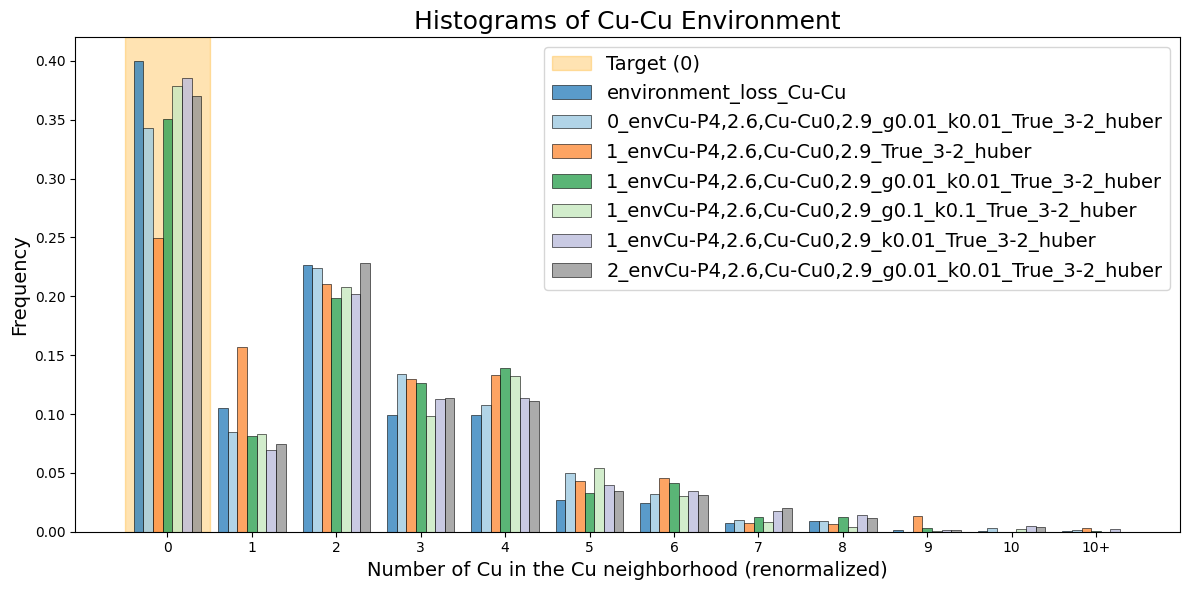

In [4]:
target = 0

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, rf"environment_loss_Cu-Cu*.csv"), recursive=True))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df['Cu-Cu_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df['Cu-Cu_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered['Cu-Cu_environment_loss'] = df_filtered['Cu-Cu_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered['Cu-Cu_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value with a vertical strip
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label=f'Target ({target})')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered['Cu-Cu_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    #label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    label = base.replace("environment_loss_Cu-Cu_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    print(counts[target], label)
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel('Number of Cu in the Cu neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms of Cu-Cu Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout() 
plt.show()


In [2]:
# Directory containing the extxyz files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
extxyz_files = glob.glob(os.path.join(base_dir,  "generated_crystals*.extxyz"), recursive=True)

# Atomic numbers for Cu and P
cu_Z = Element("Cu").Z
p_Z = Element("P").Z
pair_str = "Cu-P"

for extxyz_file in extxyz_files:
    # Build output CSV file name
    ext_dir = os.path.dirname(extxyz_file)
    ext_base = os.path.basename(extxyz_file)
    # Replace 'generated_crystals' with 'environment_loss_Cu-P' and change extension to .csv
    csv_name = ext_base.replace("generated_crystals", "environment_loss_Cu-P").replace(".extxyz", ".csv")
    output_csv = os.path.join(ext_dir, csv_name)

    # If CSV already exists, skip
    if os.path.exists(output_csv):
        print(f"Skipping {output_csv} (already exists)")
        continue

    atoms_list = read(extxyz_file, index=':')
    results = []
    for idx, atoms in enumerate(atoms_list):
        atomic_numbers = atoms.get_atomic_numbers()
        if cu_Z in atomic_numbers and cu_Z in atomic_numbers:
            atoms.cell = atoms.cell + np.eye(3) * 1e-8 
            cell = torch.tensor(atoms.cell, dtype=torch.float32)
            pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, requires_grad=True)
            chemgraph = ChemGraph(cell=cell, atomic_numbers=torch.tensor(atomic_numbers), num_atoms=torch.tensor([atomic_numbers.size]), pos=pos)
            target = {pair_str: 0.0, "mode":"l1"}  # 0 target, to compute the actual number of neighbors
            loss = (environment_loss(chemgraph, None, target, alpha = 100).item())
        else:
            loss = -1.0  # Use -1.0 to indicate no Co-O environment
        results.append({
            "structure_idx": idx,
            "Cu-P_environment_loss": loss
        })

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Saved Cu-P environment losses to {output_csv}")

/tmp/ipykernel_712348/2620757915.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32)


Saved Cu-P environment losses to /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P.csv
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_g0.1_k0.1_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P_guided-0_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skipping /users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f/environment_loss_Cu-P_guided-1_envCu-P4,2.6,Cu-Cu0,2.9_k0.01_True_3-2_huber_gpu0.csv (already exists)
Skip

0.398838334946757 environment_loss_Cu-P
0.42955326460481097 0_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber
0.26827171109200343 1_envCu-P4,2.6,Cu-Cu0,2.9_True_3-2_huber
0.43103448275862066 1_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber
0.3962425277540564 1_envCu-P4,2.6,Cu-Cu0,2.9_g0.1_k0.1_True_3-2_huber
0.4190231362467866 1_envCu-P4,2.6,Cu-Cu0,2.9_k0.01_True_3-2_huber
0.41373390557939915 2_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber


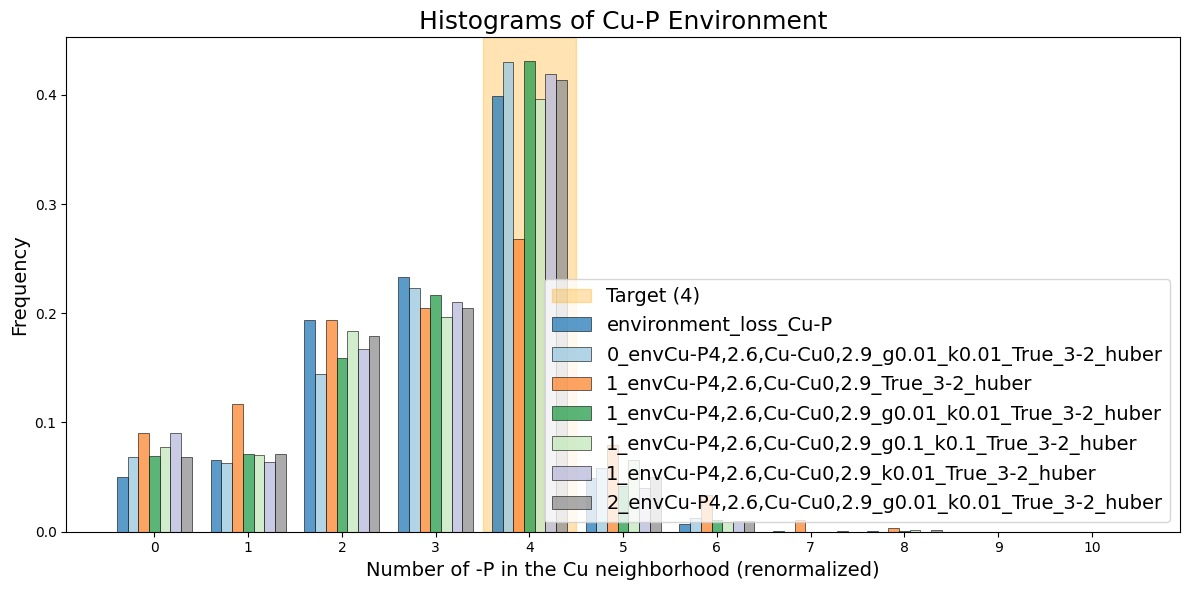

In [3]:
target = 4
sys = "Cu-P"

# Directory containing the CSV files
base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
csv_files = sorted(glob.glob(os.path.join(base_dir, rf"environment_loss_{sys}*.csv"), recursive=True))

# Collect all integer values present in all files to define common bins, excluding -1
all_values = []
dfs = []
percentage = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    n_total = len(df)
    n_minus1 = (df[f'{sys}_environment_loss'] == -1).sum()
    percentage.append(n_minus1 / n_total * 100)
    df_filtered = df[df[f'{sys}_environment_loss'] != -1].copy()
    # Cap values >10 to 11 (which will represent "10+")
    df_filtered[f'{sys}_environment_loss'] = df_filtered[f'{sys}_environment_loss'].clip(upper=11)
    dfs.append(df_filtered)
    all_values.extend(df_filtered[f'{sys}_environment_loss'].astype(int).tolist())
all_values = np.array(all_values)
min_val = all_values.min()
max_val = all_values.max()
bin_centers = np.arange(min_val, max_val + 1)
cmap = plt.get_cmap('tab20c')

# Prepare width and offsets for side-by-side bars
n_files = len(csv_files)
width = 0.8 / n_files
offsets = np.linspace(-0.4 + width/2, 0.4 - width/2, n_files)

plt.figure(figsize=(12, 6))

# Highlight the target value with a vertical strip
if target in bin_centers:
    plt.axvspan(target - 0.5, target + 0.5, color='orange', alpha=0.3, zorder=0, label=f'Target ({target})')

labels = ["g = 0.1", "g = 1.0", "g = 10", "Non-guided", "Alexandria database"]

for i, (csv_file, df_filtered) in enumerate(zip(csv_files, dfs)):
    color = cmap(i / max(n_files, 1))
    counts, _ = np.histogram(df_filtered[f'{sys}_environment_loss'], bins=np.append(bin_centers-0.5, bin_centers[-1]+0.5))
    total = counts.sum()
    if total > 0:
        counts = counts / total  # Normalize
    base = os.path.basename(csv_file)
    #label = f" {labels[i]} ({percentage[i]:.1f}%)" 
    label = base.replace(f"environment_loss_{sys}_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    print(counts[target], label)
    plt.bar(bin_centers + offsets[i], counts, width=width, label=label, align='center', edgecolor='black', linewidth=0.5, color=color, alpha=0.8)

plt.xlabel(rf'Number of {sys[-2:]} in the {sys[:2]} neighborhood (renormalized)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(rf'Histograms of {sys} Environment', fontsize=18)
plt.xticks(bin_centers, [str(x) if x < 11 else "10+" for x in bin_centers])
plt.legend(loc='lower right', fontsize=14)
plt.tight_layout() 
plt.show()



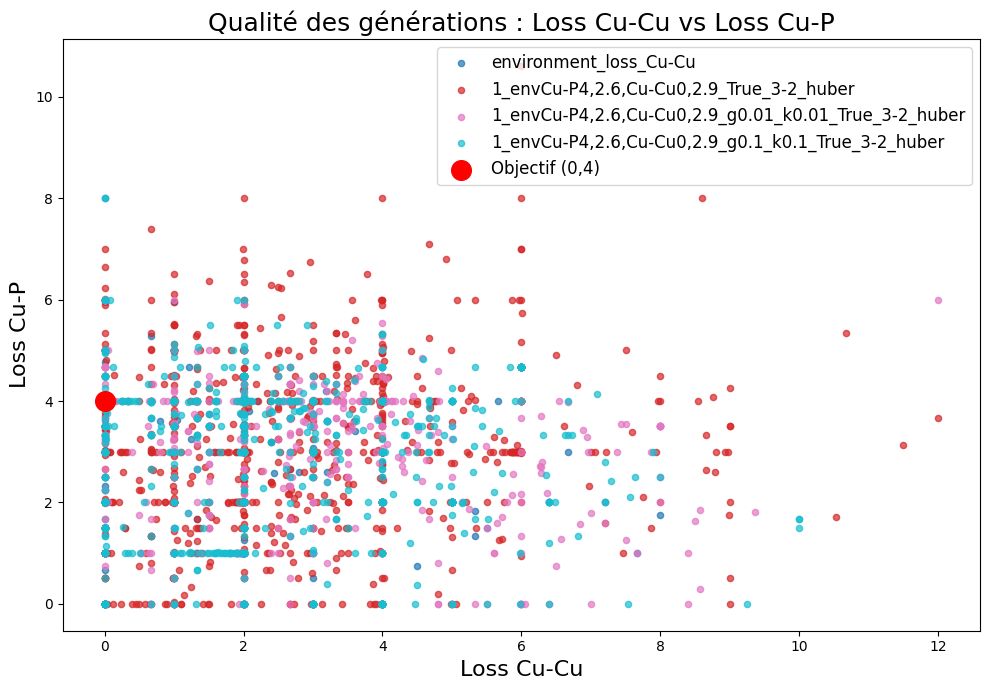

In [8]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
cu_cu_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Cu-Cu*.csv")))
cu_p_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Cu-P*.csv")))

plt.figure(figsize=(10, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(cu_cu_files)))

for i, (cu_cu_file, cu_p_file) in enumerate(zip(cu_cu_files, cu_p_files)):
    df_cu_cu = pd.read_csv(cu_cu_file)
    df_cu_p = pd.read_csv(cu_p_file)
    # On suppose que les samples sont dans le même ordre
    valid_idx = (df_cu_cu['Cu-Cu_environment_loss'] != -1) & (df_cu_p['Cu-P_environment_loss'] != -1)
    x = df_cu_cu.loc[valid_idx, 'Cu-Cu_environment_loss']
    y = df_cu_p.loc[valid_idx, 'Cu-P_environment_loss']
    base = os.path.basename(cu_cu_file)
    label = base.replace(f"environment_loss_Cu-Cu_", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    plt.scatter(x, y, color=colors[i], label=label, alpha=0.7, s=20)

# Objectif : gros point rouge en (0,4)
plt.scatter([0], [4], color='red', s=200, label='Objectif (0,4)', zorder=10)

plt.xlabel("Loss Cu-Cu", fontsize=16)
plt.ylabel("Loss Cu-P", fontsize=16)
plt.title("Qualité des générations : Loss Cu-Cu vs Loss Cu-P", fontsize=18)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

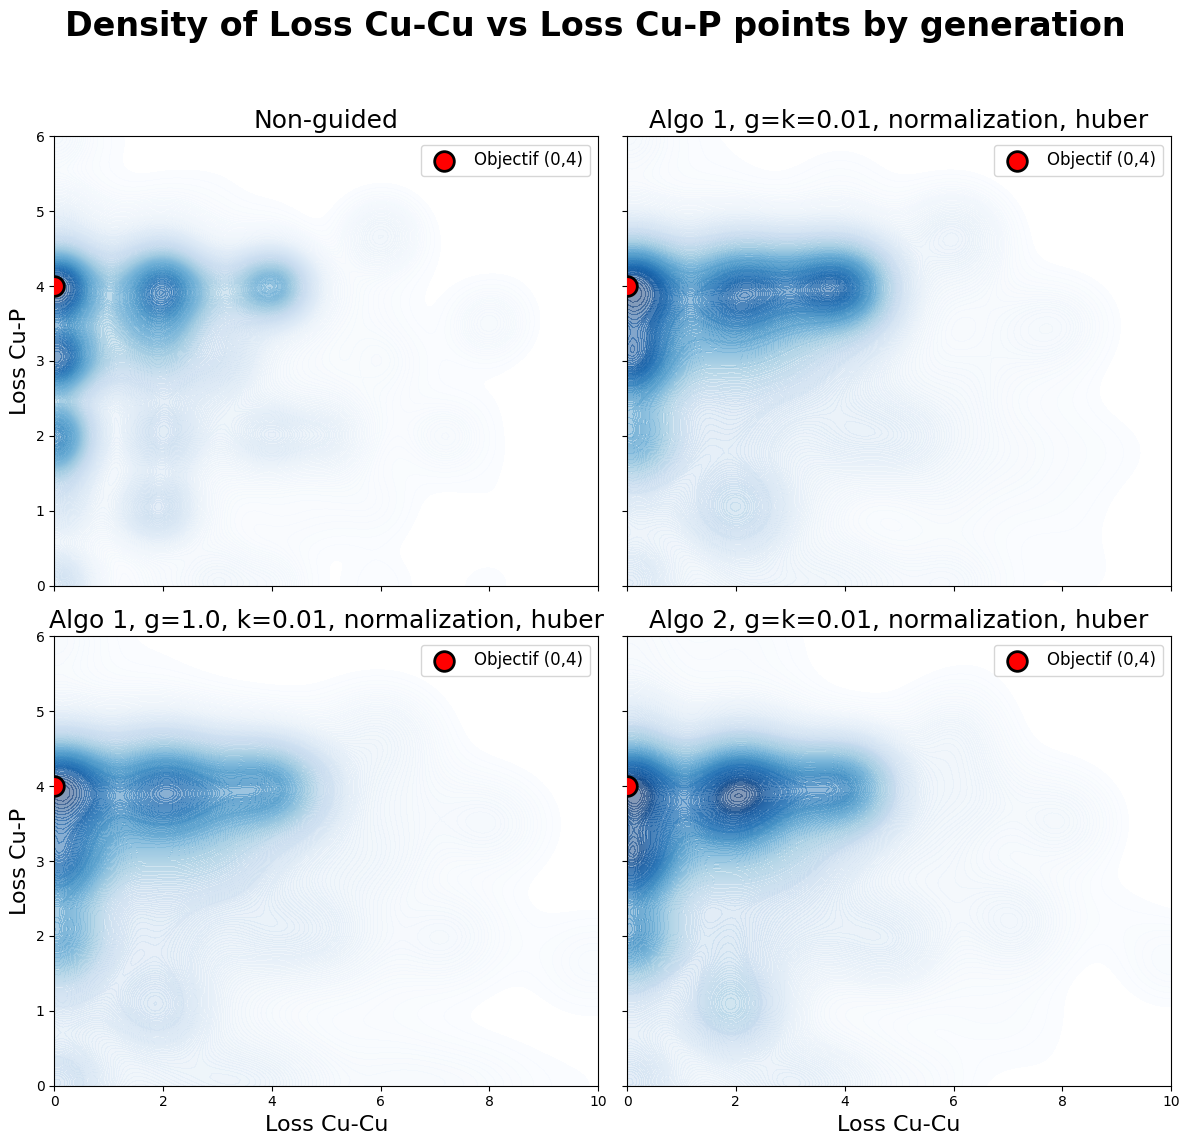

In [5]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

base_dir = "/users/eleves-b/2021/auguste.de-lambilly/results/Cu-Si-P-Ca_f"
cu_cu_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Cu-Cu*.csv")))
cu_p_files = sorted(glob.glob(os.path.join(base_dir, "environment_loss_Cu-P*.csv")))

exclude_patterns = [
    r'0_envCu-P4,2.6,Cu-Cu0,2.9_g0.01_k0.01_True_3-2_huber',
    r'1_envCu-P4,2.6,Cu-Cu0,2.9_True_3-2_huber',
    r'1_envCu-P4,2.6,Cu-Cu0,2.9_g0.1_k0.1_True_3-2_huber'
]

def is_excluded(filename):
    return any(re.search(pattern, filename) for pattern in exclude_patterns)

cu_cu_files = [f for f in cu_cu_files if not is_excluded(os.path.basename(f))]
cu_p_files = [f for f in cu_p_files if not is_excluded(os.path.basename(f))]
n_gen = len(cu_cu_files)
fig, axes = plt.subplots(2, n_gen//2, figsize=(3*n_gen, 12), sharex=True, sharey=True)

labels = ["Non-guided", "Algo 1, g=k=0.01, normalization, huber", "Algo 1, g=1.0, k=0.01, normalization, huber", "Algo 2, g=k=0.01, normalization, huber"]

for i, (cu_cu_file, cu_p_file) in enumerate(zip(cu_cu_files, cu_p_files)):
    df_cu_cu = pd.read_csv(cu_cu_file)
    df_cu_p = pd.read_csv(cu_p_file)
    valid_idx = (df_cu_cu['Cu-Cu_environment_loss'] != -1) & (df_cu_p['Cu-P_environment_loss'] != -1)
    x = df_cu_cu.loc[valid_idx, 'Cu-Cu_environment_loss']
    y = df_cu_p.loc[valid_idx, 'Cu-P_environment_loss']
    ax = axes[i//2, i%2] if n_gen > 1 else axes
    base = os.path.basename(cu_cu_file)
    #label = base.replace("environment_loss_Cu-Cu", "").replace("_gpu0", "").replace(".csv", "").replace("guided-","")
    #label = re.sub(r'env.*2.9_', '', label)
    label = labels[i]
    #print(x, y)
    # Try KDE, fallback to scatter if error
    try:
        if len(x) > 5 and len(set(x)) > 1 and len(set(y)) > 1:
            sns.kdeplot(x=x, y=y, fill=True, cmap='Blues', ax=ax, thresh=0.01, levels=200, alpha=0.5)
        else:
            ax.scatter(x, y, color='blue', alpha=0.5, s=40)
    except Exception as e:
        print(f"KDE error for {label}: {e}")
        ax.scatter(x, y, color='blue', alpha=0.5, s=40)
    ax.scatter([0], [4], color='red', s=200, label='Objectif (0,4)', zorder=10, edgecolor='black', linewidth=2)
    ax.set_title(label, fontsize=18)
    ax.set_xlabel('Loss Cu-Cu', fontsize=16)
    ax.set_ylabel('Loss Cu-P', fontsize=16)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.legend(fontsize=12)

plt.suptitle('Density of Loss Cu-Cu vs Loss Cu-P points by generation', fontsize=24, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()